# Baseline Models

Basic models using a keyword vector and "traditional" regression models.

First let's load the dataset in to memory. (Check out the readme for information on getting the data)

In [1]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
from scipy import stats
from IPython.display import display
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

data = pandas.read_csv("/Users/toddbodnar/Dropbox/retweets_h7n9.csv",encoding='latin-1',names=["retweets","followers","text"],sep="\t")
print("Dataset:")
display(data.head())
print("Total rows: "+str(len(data[[1]])))

data_train, data_test = train_test_split(data,test_size = 0.2)
data_test, data_validate = train_test_split(data_test,test_size=0.5)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Dataset:


,retweets,followers,text
0,1,190,via #newzsocial H7N9 Bird Flu Cases Rise To 51...
1,1,760,China reports 5th H7N9 bird flu death _HTTPTW...
2,1,3168,La cepa H7N9 que origina la gripe aviar es gra...
3,1,551,Hah virus H7N9?virus H5N1 aja blm dpt dimusnah...
4,1,118,H7N9 Flu: China Investigating Possible Human-T...


Total rows: 194602


## A Trivial Model

We'll start with a really simple model where

$$retweets = \alpha * followers + \beta$$

In [2]:
#print(data[[1,2]])
simple_model = stats.linregress(data_train[[1,0]])
#print(simple_model)

Note that the two variables are **not** normally distributed, so we'll use Spearman's Rank coefficient (t) instead of correlation.

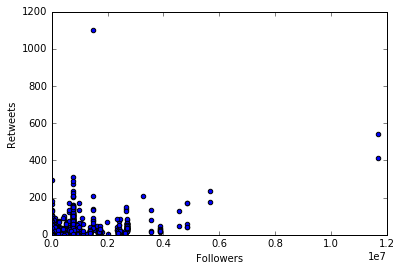

,Model,r (train),MSE (train),t (train),r (test),MSE (test),t (test),r (validate),MSE (validate),t (validate)
0,Simple,0.504794,21.850947,0.29106,0.45404,14.319386,0.302696,0.446562,23.211576,0.279431


In [3]:
import matplotlib.pyplot as plt

plt.scatter(data_train[[1]],data_train[[0]])
plt.xlim([0,1.2e7])
plt.ylim([0,1200])
plt.xlabel("Followers")
plt.ylabel("Retweets")
plt.show()

prediction_train = data_train[[1]]*simple_model.slope + simple_model.intercept
prediction_test = data_test[[1]]*simple_model.slope + simple_model.intercept
prediction_validate = data_validate[[1]]*simple_model.slope + simple_model.intercept
model_fits = pandas.DataFrame([["Simple",stats.pearsonr(prediction_train,data_train[[0]])[0][0],mean_squared_error(prediction_train,data_train[[0]]),stats.spearmanr(prediction_train,data_train[[0]])[0],stats.pearsonr(prediction_test,data_test[[0]])[0][0],mean_squared_error(prediction_test,data_test[[0]]),stats.spearmanr(prediction_test,data_test[[0]])[0],stats.pearsonr(prediction_validate,data_validate[[0]])[0][0],mean_squared_error(prediction_validate,data_validate[[0]]),stats.spearmanr(prediction_validate,data_validate[[0]])[0]]],columns = ["Model","r (train)","MSE (train)","t (train)","r (test)","MSE (test)","t (test)","r (validate)","MSE (validate)","t (validate)"])

display(model_fits)

We're also using a 90%/10% train/test split of the initial data, this will help control overfitting later on.

## Keyword Vector Models

We'll now build fancier models based on vectors of keywords derived from the text of each tweet. For this demo, we're just going to use a binary response for each keyword (if keyword n is in the tweet, then element n of the vector is 1 and 0 otherwise.) There are more advanced approaches based on the frequencies of each word in the tweet or dataset, but, from previous experience, they don't do much better (probably because tweets are short and *roughly* the same length as each other, so a word will tend to appear either once or not at all in a tweet which would translate to either a frequency of 1/w or 0, where w is the average number of words in a tweet.)

First, let's look at the 100 most common words in our dataset:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

textToVector = CountVectorizer(min_df = 5, max_features = 100, binary=True)
train_text = textToVector.fit_transform(data_train["text"])

print(textToVector.get_feature_names())

['11', '20', '2013', '_httptweetco________', 'about', 'and', 'are', 'as', 'at', 'autism', 'aves', 'aviaire', 'avian', 'aviar', 'aviária', 'be', 'beijing', 'bird', 'birdflu', 'burung', 'by', 'case', 'cases', 'casos', 'children', 'china', 'chine', 'chinese', 'clinics', 'confirmed', 'da', 'de', 'death', 'deaths', 'del', 'di', 'educacionliberadora', 'el', 'en', 'epidemic', 'first', 'flu', 'for', 'from', 'gripe', 'grippe', 'h7n9', 'has', 'have', 'health', 'human', 'humanos', 'in', 'infection', 'influenza', 'is', 'it', 'jab', 'kasus', 'la', 'los', 'man', 'measles', 'mmr', 'more', 'más', 'new', 'news', 'no', 'not', 'number', 'of', 'oms', 'on', 'outbreak', 'over', 'people', 'por', 'que', 'reported', 'reports', 'rise', 'rt', 'se', 'shanghai', 'spread', 'strain', 'swansea', 'taiwan', 'that', 'the', 'to', 'two', 'un', 'via', 'virus', 'vírus', 'who', 'with', 'world']


You should see a lot of words like "and," "of" or "the" which probably don't have much of an effect on the retweet rate, so we'll discard them.

In [5]:
textToVector = CountVectorizer(min_df = 5, max_features = 100, binary=True, stop_words='english')
train_text = textToVector.fit_transform(data_train["text"])

print(textToVector.get_feature_names())

['11', '14', '16', '20', '2013', '21', '_httptweetco________', 'april', 'autism', 'aves', 'aviaire', 'avian', 'aviar', 'aviaria', 'aviária', 'awareness', 'baru', 'beijing', 'bird', 'birdflu', 'burung', 'case', 'cases', 'casos', 'cepa', 'children', 'china', 'chine', 'chinese', 'clinics', 'confirma', 'confirmed', 'da', 'death', 'deaths', 'del', 'di', 'died', 'educacionliberadora', 'el', 'en', 'entre', 'epidemic', 'es', 'flu', 'gripe', 'grippe', 'h5n1', 'h7n9', 'health', 'human', 'humanos', 'infection', 'influenza', 'jab', 'kasus', 'ke', 'la', 'le', 'los', 'man', 'measles', 'mmr', 'muertos', 'más', 'na', 'new', 'news', 'number', 'officials', 'old', 'oms', 'outbreak', 'para', 'people', 'por', 'poultry', 'que', 'reported', 'reports', 'rise', 'risk', 'rt', 'say', 'says', 'se', 'shanghai', 'spread', 'strain', 'swansea', 'taiwan', 'una', 'update', 'vaccination', 'vaccine', 'virus', 'vírus', 'wales', 'world', 'year']


We'll now feed these vectors into a regression model, along with the follower count, to predict the number of retweets. Since we don't know which models will do better or worse, we'll test several models (linear regression, support vector regression, perceptron-based regression, and gradient boosting) and the maximum number of keywords to include in the vector (100,500, or all of them).

To speed this up, we're going to parallalize the models' evaluations. By default, we'll only use two threads, but you can increase that number (below) if you feel like your machine can handle it.

In [6]:
number_of_threads = 4 ##Default is 2, increasing this should decrease execution time, but increase resources used. May effect the system's performance if set too high!
extreme = True ##do more models and higher dimensionality vectors (but much slower)

In [23]:
import queue
import threading
import sklearn.linear_model
import sklearn.ensemble
import sklearn.neural_network
import sklearn
from scipy.sparse import csr_matrix


train_transformed = {}
test_transformed = {}
validate_transformed = {}


def worker_thread():
    while(True):
        job = jobQueue.get()
        if job is None:
            break
        
        test = test_transformed[job["max_features"]]
        train = train_transformed[job["max_features"]]
        validate = validate_transformed[job["max_features"]]
        
        model = sklearn.base.clone(models[job["model_name"]])
        model.fit(train,data_train[[0]]["retweets"])
        
        result = {}
        result["model_name"] = job["model_name"]+"_"+str(job["max_features"])
        result["r_train"] = stats.pearsonr(model.predict(train),data_train[["retweets"]]["retweets"])[0]
        result["r_test"] = stats.pearsonr(model.predict(test),data_test[["retweets"]]["retweets"])[0]
        result["r_validate"] = stats.pearsonr(model.predict(validate),data_validate[["retweets"]]["retweets"])[0]
        result["mse_train"] = mean_squared_error(model.predict(train),data_train[["retweets"]]["retweets"])
        result["mse_test"] = mean_squared_error(model.predict(test),data_test[["retweets"]]["retweets"])
        result["mse_validate"] = mean_squared_error(model.predict(validate),data_validate[["retweets"]]["retweets"])
        result["t_train"] = stats.spearmanr(model.predict(train),data_train[["retweets"]]["retweets"])[0]
        result["t_test"] = stats.spearmanr(model.predict(test),data_test[["retweets"]]["retweets"])[0]
        result["t_validate"] = stats.spearmanr(model.predict(validate),data_validate[["retweets"]]["retweets"])[0]
        
        results.append(result)
        print(".",end='')
        
        
        
jobQueue = queue.Queue()
results = []

models = {}
models["linear_regression"] = sklearn.linear_model.LinearRegression()
models["svm_r"] = sklearn.svm.SVR()
models["gradient_100"] = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100)


key_sizes = [10,50,100,500]

if extreme:
    key_sizes.append(1000)
    key_sizes.append(5000)
    ##key_sizes.append(None) ##too extreme for me
    
    models["perceptron"] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=()) ##requires sklearn 0.18 (currently in dev mode)
    models["ann_50"] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(50)) ##requires sklearn 0.18 (currently in dev mode)
    models["ann_100"] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100)) ##requires sklearn 0.18 (currently in dev mode)
    #models["ann_50_50"] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(50,50)) ##requires sklearn 0.18 (currently in dev mode)
    #models["ann_50_100"] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(50,100)) ##requires sklearn 0.18 (currently in dev mode)
    #models["ann_100_50"] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,50)) ##requires sklearn 0.18 (currently in dev mode)
    #models["ann_100_100"] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,100)) ##requires sklearn 0.18 (currently in dev mode)

print("Building keyword vectors",end='')
    
for key_count in key_sizes:
    textToVector = CountVectorizer(min_df = 5, max_features = key_count, binary=True, stop_words='english')
    train_text = (textToVector.fit_transform(data_train[[2]]["text"])).todense()
    test_text = (textToVector.transform(data_test[[2]]["text"])).todense()
    validate_text = (textToVector.transform(data_validate[[2]]["text"])).todense()
    train_transformed[key_count] = (np.concatenate((np.array(train_text),np.array(data_train[[1]])),axis=1))
    test_transformed[key_count] = csr_matrix(np.concatenate((np.array(test_text),np.array(data_test[[1]])),axis=1))
    validate_transformed[key_count] = csr_matrix(np.concatenate((np.array(validate_text),np.array(data_validate[[1]])),axis=1))
    print(".",end='')
        
print()

print("Building models")

    
for model in models:
    for key_count in key_sizes:
        job = {}
        job["model_name"] = model
        job["max_features"] = key_count
        jobQueue.put(job)
        print("-",end='')
        
threads = []

print()

for i in range(number_of_threads):
    jobQueue.put(None)
    thread = threading.Thread(target=worker_thread)
    thread.start()
    threads.append(thread)
    
for thread in threads:
    thread.join()
    
print()

for result in results:
    model_fits = model_fits.append(pandas.DataFrame([[result["model_name"],result["r_train"],result["mse_train"],result["t_train"],result["r_test"],result["mse_test"],result["t_test"],result["r_validate"],result["mse_validate"],result["t_validate"]]],columns = ["Model","r (train)","MSE (train)","t (train)","r (test)","MSE (test)","t (test)","r (validate)","MSE (validate)","t (validate)"]))

display(model_fits)


Building keyword vectors......
Building models
------------------------------------
...............

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-23-d053fc5641ed>", line 31, in worker_thread
    result["r_test"] = stats.pearsonr(model.predict(test),data_test[["retweets"]]["retweets"])[0]
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/ensemble/gradient_boosting.py", line 1805, in predict
    X = check_array(X, dtype=DTYPE, order="C")
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py", line 375, in check_array
    force_all_finite)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py", line 242, in

KeyboardInterrupt: 

If you look at the ann performance (if extreme is turned on), you may notice that some models are performing very poorly. This appears to be a convergence issue. For example, let's look at performance on a 500x50x100 network with differing training periods. We'd expect that the performance should increase over time, but it isn't. 

In [21]:

test_score = []
train_score = []
epochs = []

print("Processing")

for epoch in range(5,5001,50):
    print("-",end='')
    
print()

if test_transformed is None:
    test_transformed = {}
    train_transformed = {}

for key_count in [500]:
    textToVector = CountVectorizer(min_df = 5, max_features = key_count, binary=True, stop_words='english')
    train_text = (textToVector.fit_transform(data_train[[2]]["text"])).todense()
    test_text = (textToVector.transform(data_test[[2]]["text"])).todense()
    train_transformed[key_count] = np.concatenate((np.array(train_text),np.array(data_train[[1]])),axis=1)
    test_transformed[key_count] = np.concatenate((np.array(test_text),np.array(data_test[[1]])),axis=1)

model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(50,100),tol=0,max_iter = 50)

for epoch in range(5,5001,50):
    model.partial_fit(train_transformed[500],data_train[[0]]["retweets"])
    
    test_score.append(stats.spearmanr(model.predict(test_transformed[500]),data_test[["retweets"]]["retweets"])[0])
    train_score.append(stats.spearmanr(model.predict(train_transformed[500]),data_train[["retweets"]]["retweets"])[0])
    epochs.append(epoch)
    print(".",end='')
    

Processing
----------------------------------------------------------------------------------------------------
....................................................................................................

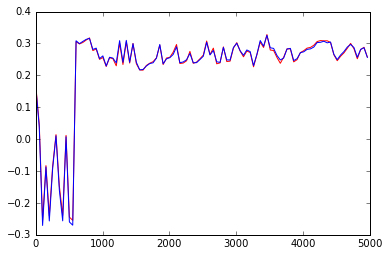

In [22]:
plt.plot(epochs,train_score,'r')
plt.plot(epochs,test_score,'b')
plt.show()

In [17]:
test_score = []
train_score = []
epochs = []

print("Processing")

for epoch in range(5,5001,50):
    print("-",end='')
    
print()

if test_transformed is None:
    test_transformed = {}
    train_transformed = {}

for key_count in [500]:
    textToVector = CountVectorizer(min_df = 5, max_features = key_count, binary=True, stop_words='english')
    train_text = (textToVector.fit_transform(data_train[[2]]["text"])).todense()
    test_text = (textToVector.transform(data_test[[2]]["text"])).todense()
    train_transformed[key_count] = np.concatenate((np.array(train_text),np.array(data_train[[1]])),axis=1)
    test_transformed[key_count] = np.concatenate((np.array(test_text),np.array(data_test[[1]])),axis=1)


model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(50,100),tol=0,max_iter = 50,learning_rate_init = 0.0000001)

for epoch in range(5,5001,50):
    model = model.partial_fit(train_transformed[500],data_train[[0]]["retweets"])
    
    test_score.append(stats.spearmanr(model.predict(test_transformed[500]),data_test[["retweets"]]["retweets"])[0])
    train_score.append(stats.spearmanr(model.predict(train_transformed[500]),data_train[["retweets"]]["retweets"])[0])
    epochs.append(epoch)
    print(".",end='')

Processing
----------------------------------------------------------------------------------------------------
....................................................................................................

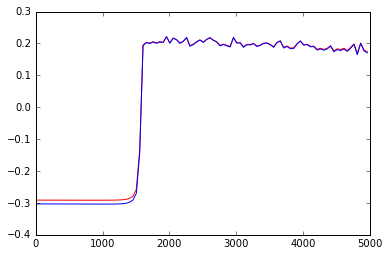

In [18]:
plt.plot(epochs,train_score,'r')
plt.plot(epochs,test_score,'b')
plt.show()

You can experiment with a changing learning rate to control this, too.

In [19]:
test_score = []
train_score = []
epochs = []

print("Processing")

for epoch in range(5,5001,50):
    print("-",end='')
    
print()

if test_transformed is None:
    test_transformed = {}
    train_transformed = {}

for key_count in [500]:
    textToVector = CountVectorizer(min_df = 5, max_features = key_count, binary=True, stop_words='english')
    train_text = (textToVector.fit_transform(data_train[[2]]["text"])).todense()
    test_text = (textToVector.transform(data_test[[2]]["text"])).todense()
    train_transformed[key_count] = np.concatenate((np.array(train_text),np.array(data_train[[1]])),axis=1)
    test_transformed[key_count] = np.concatenate((np.array(test_text),np.array(data_test[[1]])),axis=1)

model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(50,100),tol=0,max_iter = 50,learning_rate = "invscaling")

for epoch in range(5,5001,50):
    model.partial_fit(train_transformed[500],data_train[[0]]["retweets"])
    
    test_score.append(stats.spearmanr(model.predict(test_transformed[500]),data_test[["retweets"]]["retweets"])[0])
    train_score.append(stats.spearmanr(model.predict(train_transformed[500]),data_train[["retweets"]]["retweets"])[0])
    epochs.append(epoch)
    print(".",end='')

Processing
----------------------------------------------------------------------------------------------------
....................................................................................................

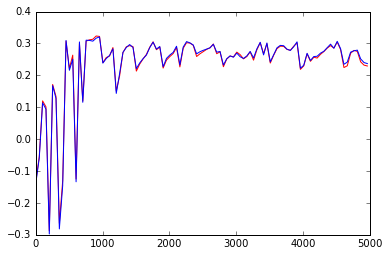

In [20]:
plt.plot(epochs,train_score,'r')
plt.plot(epochs,test_score,'b')
plt.show()

Let's also run the garbage collector on the intermediataries.

In [ ]:
import gc

train_transformed = None
test_transformed = None
print(str(gc.collect())+" objects collected.")